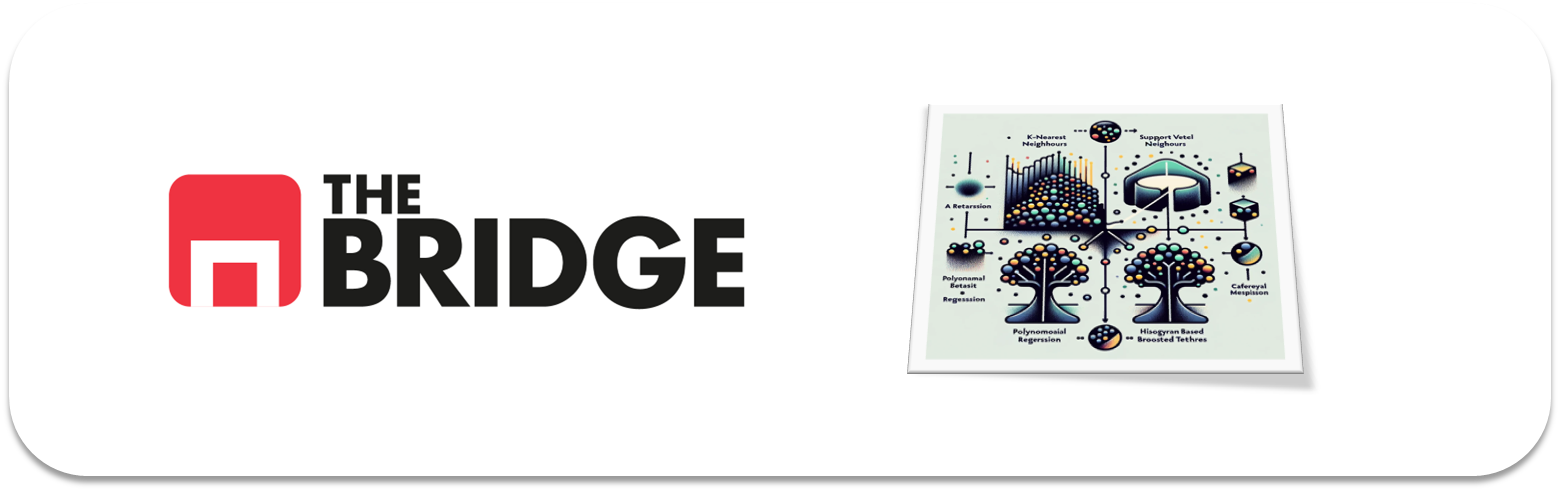

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Dpara ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
pd.options.mode.copy_on_write = True

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

*Cargamos datos, echamos un vistazo y buscamos la descripción*

In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

*Así de primeras "Monthlty Income" y "NumberOfDependents" necesitan tratamiento de esos missings, que haremos una vez hecho el split en train y test*

*Tirando de herramientas chatteras:*

## Interpretación de las variables

1. **SeriousDlqin2yrs**  
   Indica si el prestatario incurrió en **morosidad grave (retrasos de 90 días o más)** en los **dos años posteriores** al momento de la observación.  
   - **1**: ocurrió incumplimiento severo  
   - **0**: no ocurrió

2. **RevolvingUtilizationOfUnsecuredLines**  
   - Mide la **proporción del crédito sin garantía utilizado** (principalmente **tarjetas de crédito**) respecto al total disponible.  
   - Valores altos indican **mayor dependencia del crédito** y posible **estrés financiero**.

3. **age**  
   - Edad del prestatario expresada en **años**.

4. **NumberOfTime30-59DaysPastDueNotWorse**  
   - Número de veces que el prestatario presentó **retrasos moderados** en sus pagos (**entre 30 y 59 días**) durante los **últimos dos años**.

5. **DebtRatio**  
   - Representa la **carga financiera del prestatario**, expresando la **relación entre sus obligaciones financieras y su ingreso**.  
   - Valores elevados reflejan **mayor presión económica**.

6. **MonthlyIncome**  
   - **Ingreso mensual** del prestatario al momento de la observación.

7. **NumberOfOpenCreditLinesAndLoans**  
   - Cantidad total de **líneas de crédito y préstamos activos** que posee el prestatario.

8. **NumberOfTimes90DaysLate**  
   - Número de ocasiones en que el prestatario incurrió en **retrasos graves de pago (más de 90 días)**.

9. **NumberRealEstateLoansOrLines**  
   - Número de **préstamos o líneas de crédito inmobiliarias**, como **hipotecas** o créditos con **garantía hipotecaria**.

10. **NumberOfTime60-89DaysPastDueNotWorse**  
    - Número de veces que el prestatario tuvo **retrasos significativos** en sus pagos (**entre 60 y 89 días**) en los **últimos dos años**. 

11. **NumberOfDependents**  
    - Número de **personas económicamente dependientes** del prestatario, **excluyéndose a sí mismo**. 


*En esta ocasión para hacer una rápida clasificación en categóricas y numéricas miraré el describe porque todas aparecen como tipo numérico*

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,12537.0,0.068916,0.253321,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,12537.0,0.330359,0.368148,0.0,0.030651,0.163490,0.582219,6.0
age,12537.0,52.079445,15.077498,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,12537.0,0.409588,4.055787,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,12537.0,1.902253,9.122216,0.0,0.142268,0.302025,0.506725,99.0
MonthlyIncome,11816.0,6864.815420,11855.905437,0.0,3498.750000,5416.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,12537.0,8.482332,5.165422,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,12537.0,0.259312,4.035658,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,12537.0,0.999202,1.134325,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,12537.0,0.228364,4.018873,0.0,0.000000,0.000000,0.000000,98.0


*Veo que hay outliers potentes en algunas variables (lo tendré que tener en cuenta si voy a estandarizar para hacer transformaciones primero) y en general son todas para considerar como numéricas continuas, salvo quizás "NumberOfDependents" que lo que haré será (después de imputarla) tratarla como numérica y categórica en el MiniEDA para decidir si tengo que tratarla luego de una u otra manera (como categórica no la trataría porque ya es "ordinal")*

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

*Es un problema de clasificación binaria (estará o no en problemas financieros en los dos próximos años)*  
*La variable target es 'SeriousDlqin2yrs'* 

### #1.3
Pinta la distribución de frecuencias del target y coméntala

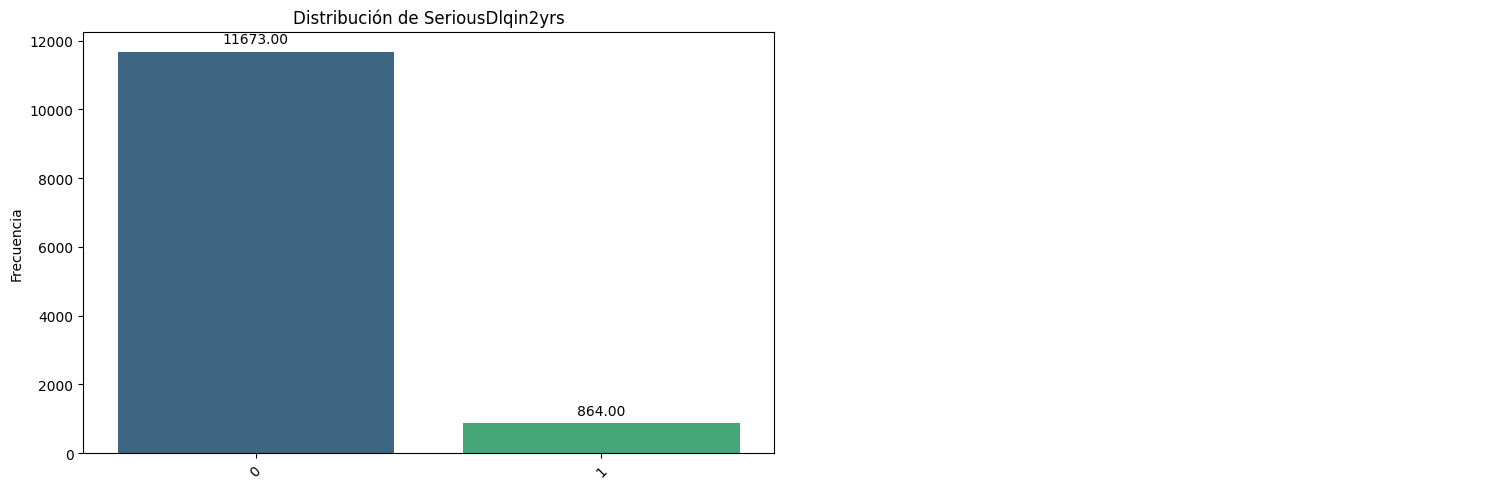

In [75]:
target = "SeriousDlqin2yrs"

bt.pinta_distribucion_categoricas(df,[target], mostrar_valores= True, relativa=False)

*El ```target``` esta muy desequilibrado o muy desbalanceado. Aplicaremos lo visto en el workout; Oversampling, Undersampling y equilibrado con hiperparámetros*

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este con y sin datasets tratados y elige el mejor.

**1. Limpieza**

*Como lo que tenemos que hacer es imputar variables numéricas lo dejamos para después del split. El resto, se puede comprobar, está bastante limpio y no parece haber valores especiales (tipo -1 o 9999999, como puedes comprobar en el describe que hicimos antes)*

**2. Train-Test**

In [7]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42, stratify = df['SeriousDlqin2yrs'])

**3. Imputaciones**

*En el caso de "NumberOfDepedentes" es numérica discreta así que NO vamos a imputar media, podríamos imputar mediana por ser más representativa, pero vamos a hacerlo con la moda*

In [8]:
# Primero las asigno a variables para simplificar el tecleteo :-)
ndp = "NumberOfDependents"
mi = "MonthlyIncome"

In [9]:
train_set[ndp].quantile(0.5) # otro estilo de sacar la mediana #Tip!

0.0

In [10]:
# Con "NumberOfDependents", imputo la moda
moda_train = train_set[ndp].mode()
print(moda_train) # Compruebo que no hay más de un valor

0    0.0
Name: NumberOfDependents, dtype: float64


*Imputamos train y test*

In [11]:
moda_train = moda_train[0] # lo convierto en un valor (antes era un serie de pandas)

train_set[ndp] = train_set[ndp].fillna(moda_train)
test_set[ndp] = test_set[ndp].fillna(moda_train)

*Ahora con MonthlyIncome, pinto la distribución para decidir si uso media o mediana*

In [12]:
train_set[mi].describe()

count      9446.000000
mean       6828.929812
std       11109.771346
min           0.000000
25%        3475.750000
50%        5416.000000
75%        8290.750000
max      702500.000000
Name: MonthlyIncome, dtype: float64

In [13]:
[train_set[mi] < 50000]

[8818     True
 4520     True
 337      True
 12501    True
 8837     True
          ... 
 12390    True
 10382    True
 5907     True
 2165     True
 10443    True
 Name: MonthlyIncome, Length: 10029, dtype: bool]

(2,)


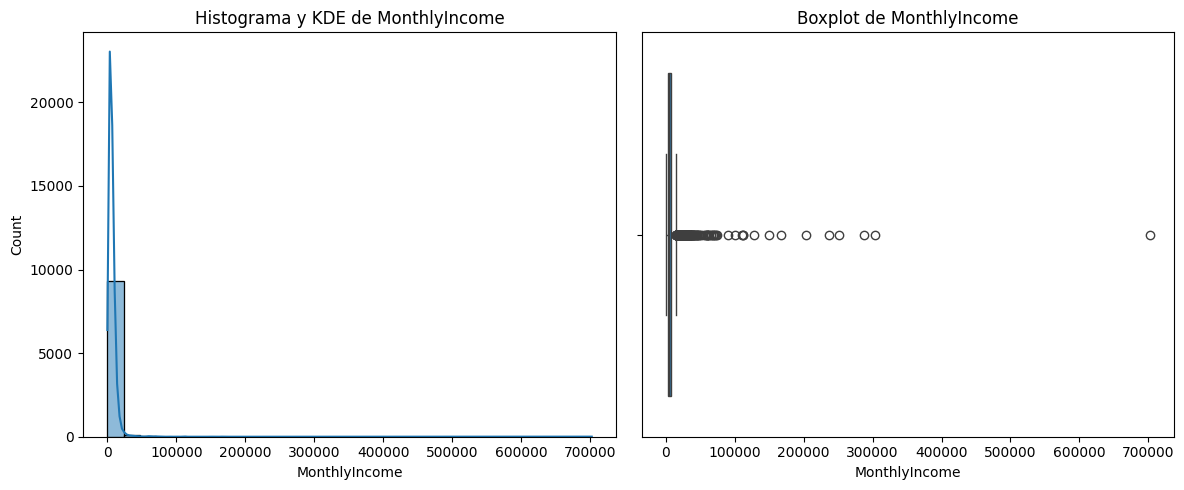

In [14]:
bt.plot_combined_graphs(train_set, columns=[mi], bins = 30) 
# Si no veo nada, puedo hacer un slicing como en la siguiente celda

(2,)


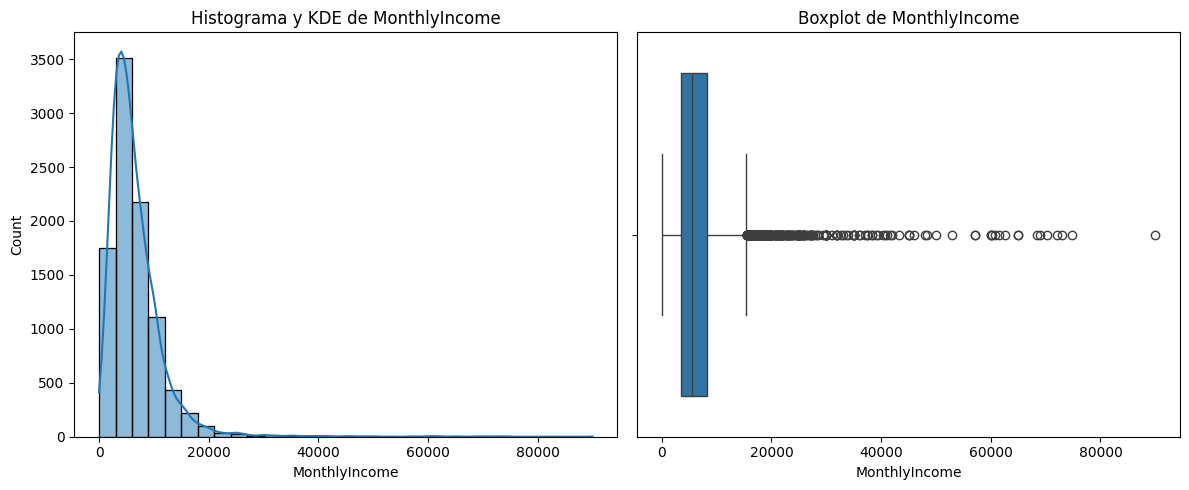

In [15]:
bt.plot_combined_graphs(train_set[train_set[mi] < 100000], columns=[mi], bins = 30) 
# Uso 100000 porque en el boxplot anterior es donde parece que empiezan a separarse más los "outliers", a no estar tan concentrados 

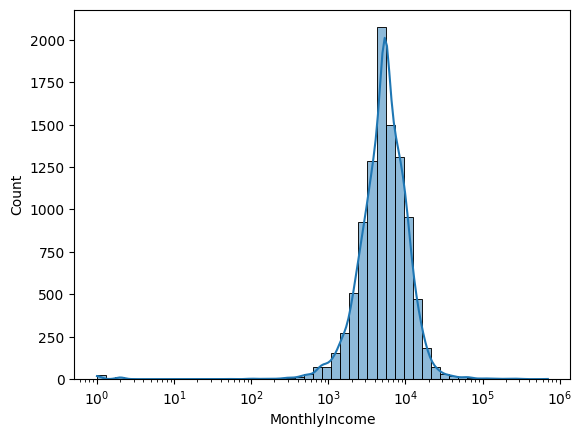

In [71]:
## En caso de pensar que una variable puede beneficiarse de una transformación,
## histplot tiene un argumento para visualizar en la escala logaritmica de nuestra elección

# sns.histplot(train_set[mi], bins= 50, kde=True)
sns.histplot(train_set[mi]+1, bins= 50, kde=True, log_scale=10)
plt.show()

*Tiene mucho outlier extremo es muy heavy-tail, así que usaré la mediana y me apunto esa presencia de outliers porque tendré que transformar en algún momento si quiero escalar*

In [17]:
mediana = train_set[mi].quantile(0.5)

train_set[mi] = train_set[mi].fillna(mediana)
test_set[mi] = test_set[mi].fillna(mediana)

**4. MiniEDA**

*Considerando "NumberOfDependents" como categórica la analizo contra el target*

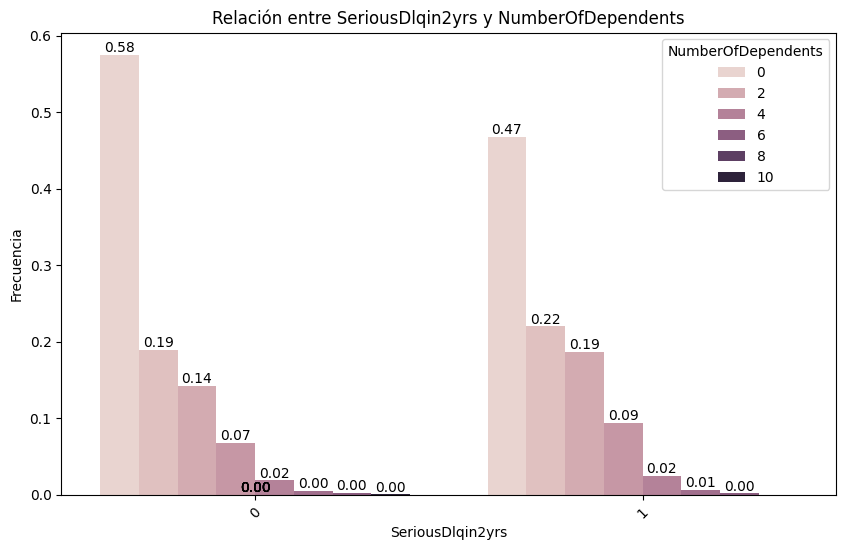

In [18]:
bt.plot_categorical_relationship_fin(train_set, target, ndp, show_values= True, relative_freq= True)

*Así tal cual, distribuciones de figura similar, y valores muy parecidos, no la incluiría, vamos a ver el análisis de variables numéricas incluyéndola*

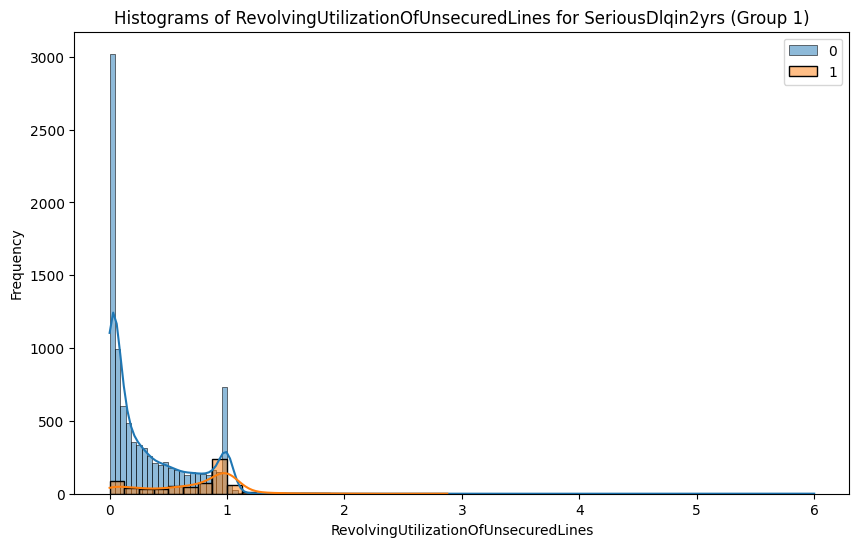

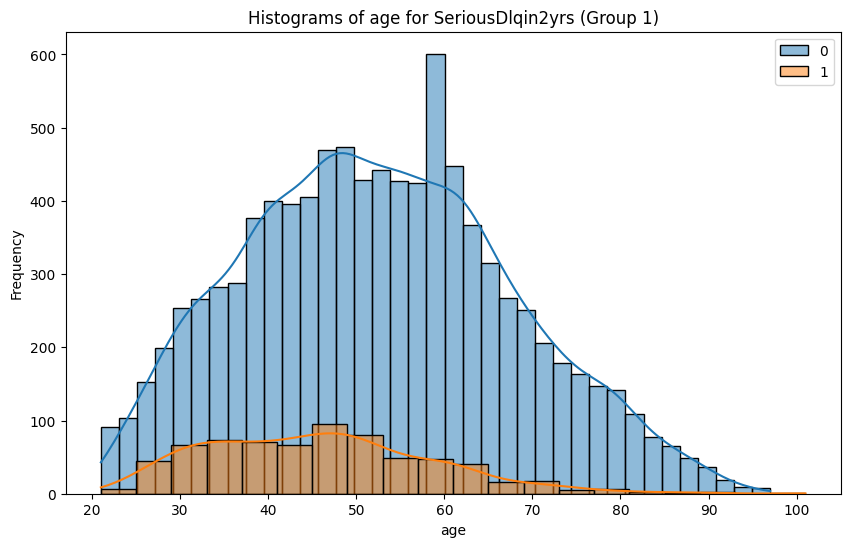

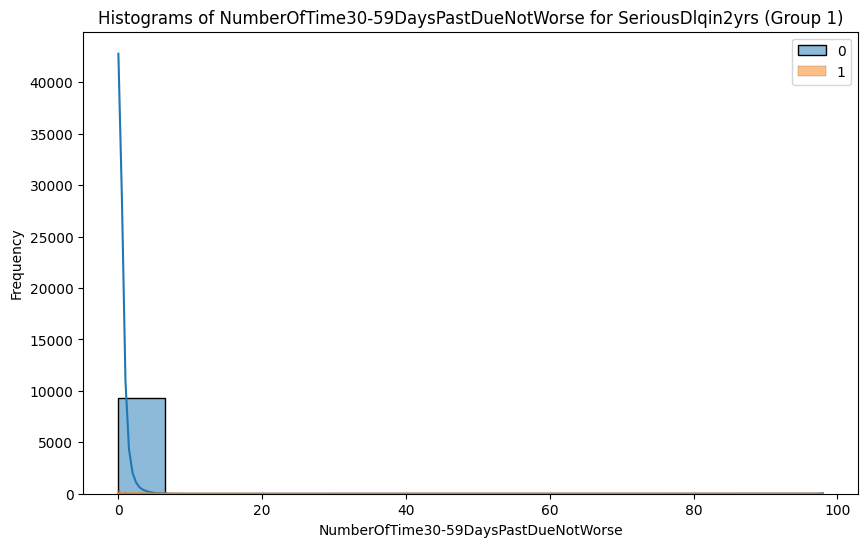

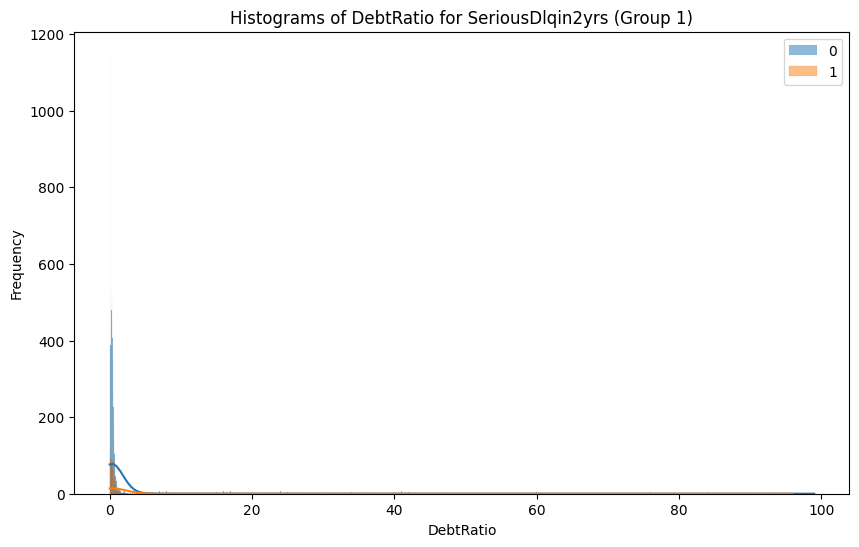

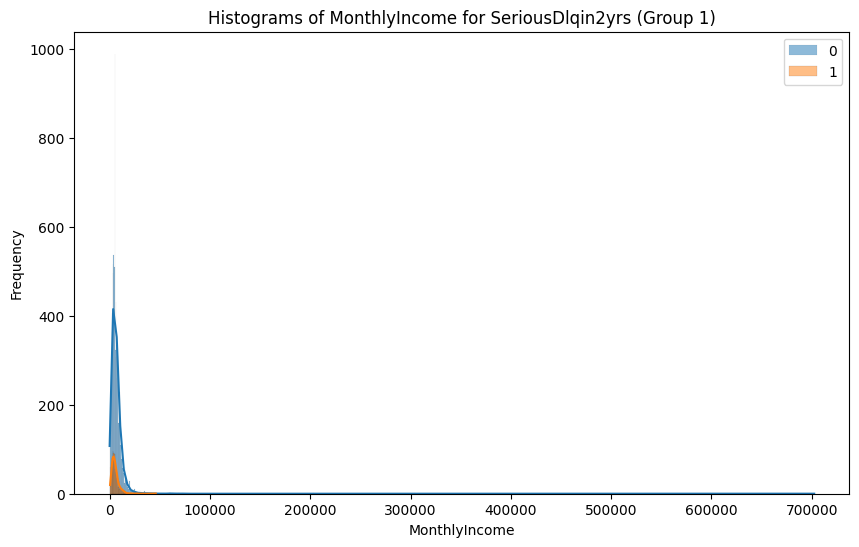

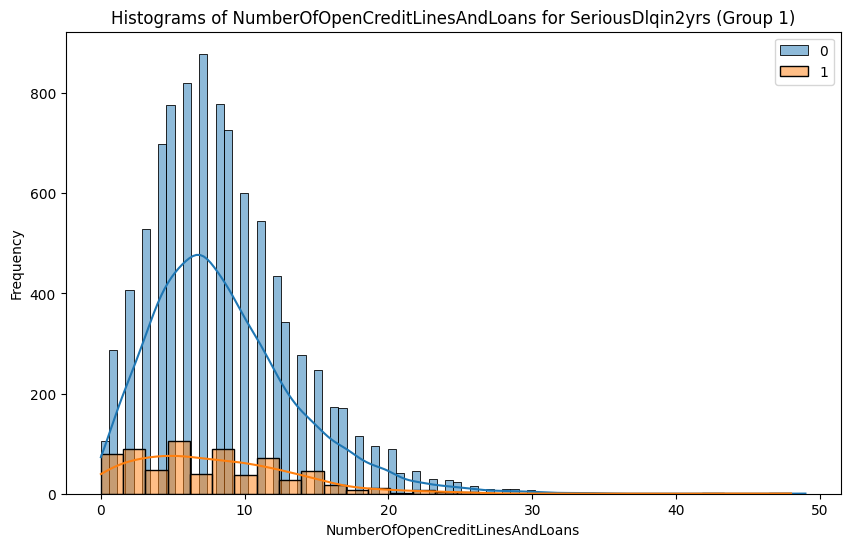

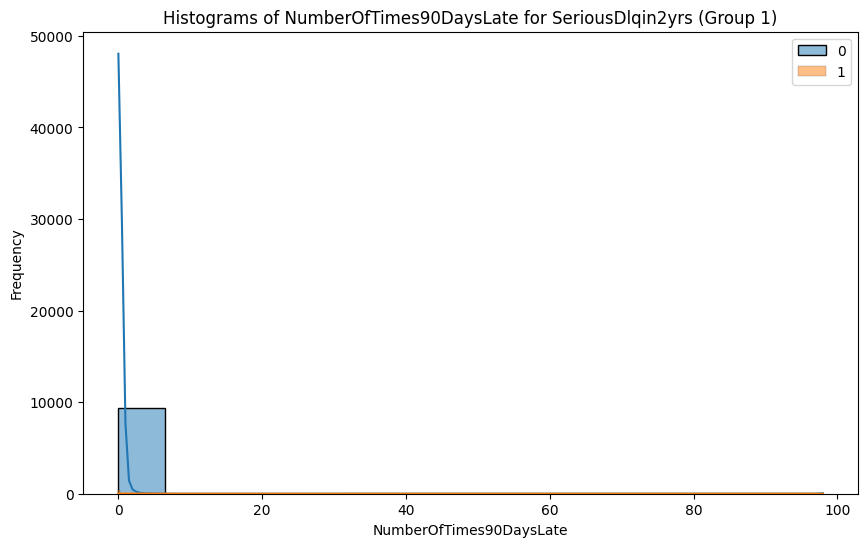

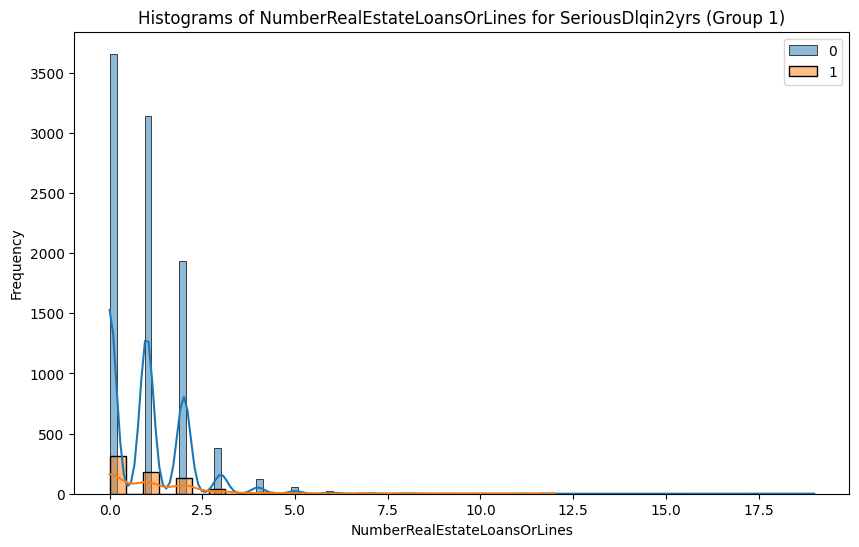

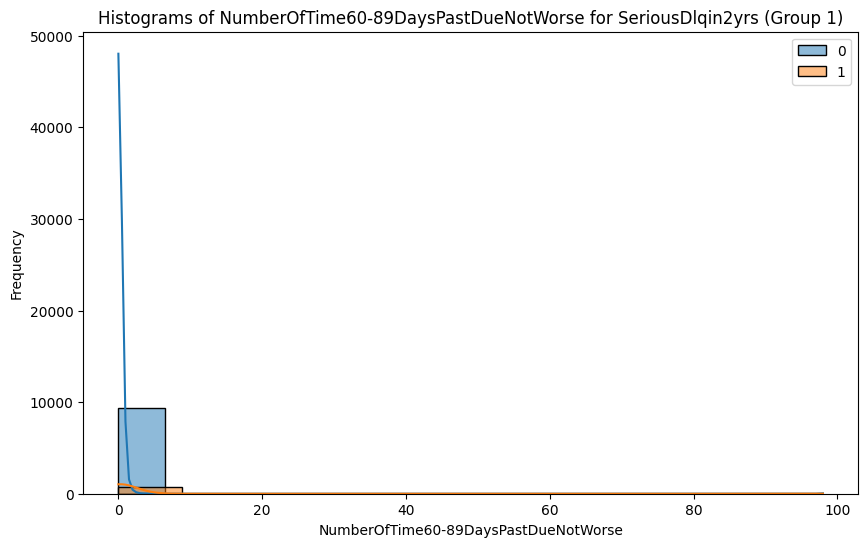

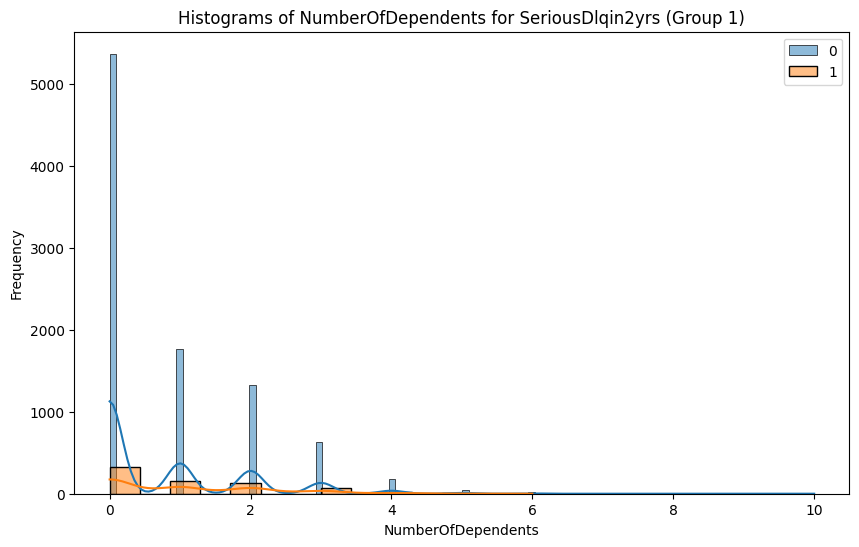

In [19]:
features = [col for col in train_set.columns if col != target]

for col in features:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

*Visualmente se ve poco debido a los rangos y las diferencias de distribución, de hecho todas las que son "NumberOfTime" parecen interesantes (esa superposición naranaja sobre la azul en la larga cola) pero no son claras, y el resto salvo Age tampoco parece aportar mucho. Veamos las "NumberOfTime" separando las gráficas en vez de superponiéndolas*

In [20]:
numberOf = [col for col in train_set if col.startswith("NumberOfTime")]
for col in numberOf:
    print(f"Para pagadores, value_counts de {col}")
    print(train_set[train_set[target]== 0][col].value_counts(True))
    print(f"Para impagadores")
    print(train_set[train_set[target]==1][col].value_counts(True))
    print("****")

Para pagadores, value_counts de NumberOfTime30-59DaysPastDueNotWorse
NumberOfTime30-59DaysPastDueNotWorse
0     0.859927
1     0.100236
2     0.025380
3     0.008032
4     0.003641
98    0.000964
5     0.000964
6     0.000750
7     0.000107
Name: proportion, dtype: float64
Para impagadores
NumberOfTime30-59DaysPastDueNotWorse
0     0.529667
1     0.228654
2     0.130246
3     0.046310
4     0.031838
6     0.015919
5     0.010130
98    0.007236
Name: proportion, dtype: float64
****
Para pagadores, value_counts de NumberOfTimes90DaysLate
NumberOfTimes90DaysLate
0     0.966374
1     0.024631
2     0.005462
3     0.001285
98    0.000964
4     0.000535
5     0.000428
6     0.000214
13    0.000107
Name: proportion, dtype: float64
Para impagadores
NumberOfTimes90DaysLate
0     0.662808
1     0.147612
2     0.088278
3     0.039074
4     0.027496
5     0.014472
98    0.007236
6     0.004342
8     0.004342
7     0.004342
Name: proportion, dtype: float64
****
Para pagadores, value_counts de Numbe

*Comparando números se puede ver que en general los pagagadores tienen la "NumberOfTime" a 0 y los impagadores en menor medida, por lo que son columnas que esperamos que sean bastante discriminativas. De hecho tal como se ve podríamos haberlas simplificado (por ejemplo en 3 valores, 0 veces, 1 vez, más de 1 vez)*

*Hora de seleccionar: Me quedo todas porque son pocas, de tener más tiempo habría hecho dos juegos uno con "Age",las "NumberOfTime" y "MonthlyIncome", otro con todas las features*

**5. Tratamiento de Features**

*Sí solo usase ensamblados basados en Árboles no trataría las variables, pero se nos pide usar un KNN, así que sabiendo lo sensible que es a las escalas, vamos a tratar todas las variables.*

*Veamos los histogramas*

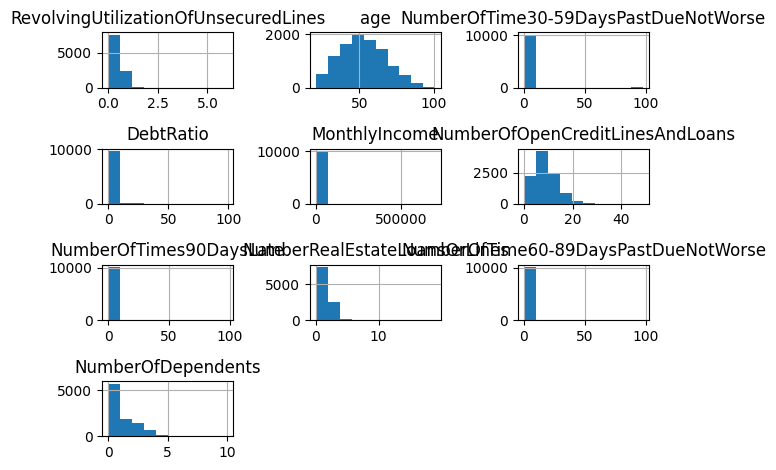

In [21]:
train_set[features].hist()
plt.tight_layout()

*Salvo Age todas necesitan un "empujoncito", pero voy a generar dos train_sets*

In [22]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [23]:
for col in features:
    if col != "age":
        train_set_scaled[col] = np.log(train_set_scaled[col] + 1) # A todas les aplico log(x+1) porque tienen ceros
        test_set_scaled[col] = np.log(test_set_scaled[col] + 1) # A test le tengo que aplicar las mismas transformaciones que a train

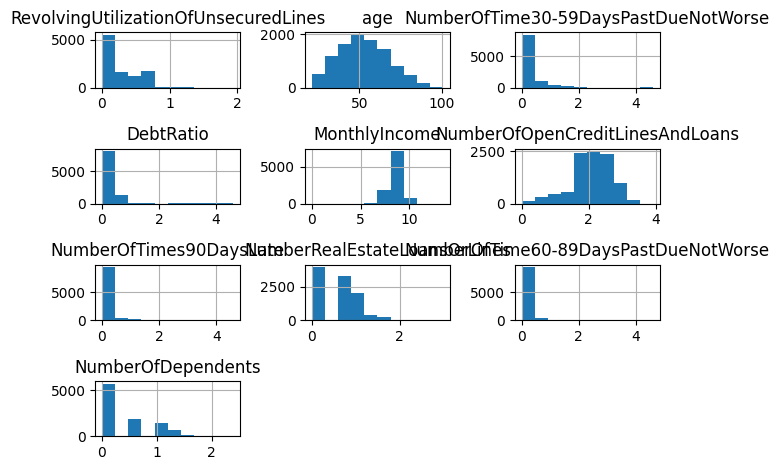

In [24]:
train_set_scaled[features].hist()
plt.tight_layout()

In [ ]:
# RobustScaler alternativa para KNN
# from sklearn.preprocessing import RobustScale

scaler = StandardScaler()

train_set_scaled[features] = scaler.fit_transform(train_set_scaled[features])
test_set_scaled[features] = scaler.transform(test_set_scaled[features])

**6. Generamos X,y**

*Generamos todos los juegos de X,y que necesitamos, teniendo en cuenta de que tenemos un train sin escalar y otro escalado*

In [26]:
X_train = train_set[features]
X_train_scaled = train_set_scaled[features]
y_train = train_set[target]

X_test = test_set[features]
X_test_scaled = test_set_scaled[features]
y_test = test_set[target]


**7. Baseline con KNN**

*Escogemos K=7, arbitrariamente*

*Entrenamos*

In [27]:
knn_clf = KNeighborsClassifier(n_neighbors= 7) # n_neighbors = siempre impar

knn_clf.fit(X_train_scaled, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",7
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


*Probamos contra Train*

In [28]:
print(classification_report(y_train, knn_clf.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9338
           1       0.69      0.23      0.34       691

    accuracy                           0.94     10029
   macro avg       0.82      0.61      0.66     10029
weighted avg       0.93      0.94      0.93     10029



*Claramente no es un gran clasificador, pero ya tenemos un recall_medio "malo" para comparar -> 61%, fijate que no he usado el test, ni validación cruzada, pero tampoco lo he optimizado (no sabemos si es k es bueno o si el peso de los vecinos es el mejor), de hecho si pruebas con un "weights= "distance"" cambiarán bastante los resultados (contra train)*

**8. Otros Modelos y comparativa**

In [29]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []

lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, random_state = 42, verbose = -1, n_jobs= -1)

for nombre, modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")) 
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.5738809143505257
Para Logistic: 0.5621148954635444
Para RandomF: 0.5530236484401414
Para XGBoost: 0.593510824002355
Para LightGBM: 0.5940385606477767


*Solo teniendo en cuenta estos valores nos quedaríamos con LightGBM, pero claramente son malos si tenemos al KNN como baseline, y sabemos que tiene que ver con el desequilibrio del dataset o por lo menos ese debería ser nuestro primer punto de actuación*

**8. Equilibrado**

*Vamos a generar dos juegos nuevos de X,y uno con Oversampling y otro con Undersampling*

1. Oversampling con SMOTE

In [30]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_scaled, y_train) # Esto es un apaño: Ojo porque ahora no estamos entrenando contra los mismos trains exactamente para eso tendríamos que haber reescalado el X_train, usando los mismos valores originales.


In [31]:
print(len(y_train))
print(len(y_train_smote))

10029
18676


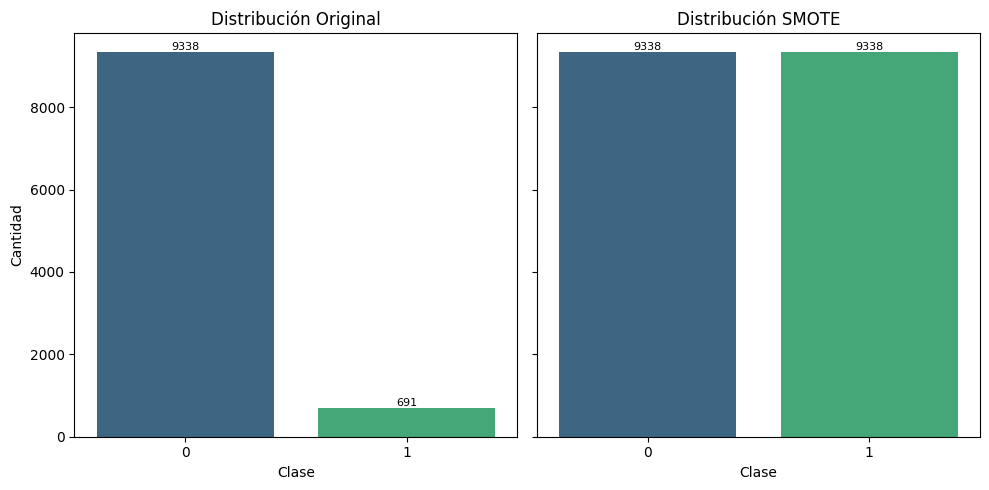

In [32]:
original_counts = y_train.value_counts()
smote_counts = y_train_smote.value_counts()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
primera = ax[0]
segunda = ax[1]

barplot_original = sns.barplot(x=original_counts.index, y=original_counts.values, ax=primera, palette='viridis', hue = original_counts.index, legend=False)
primera.set_title('Distribución Original')
primera.set_xlabel('Clase')
primera.set_ylabel('Cantidad')

for bar in barplot_original.patches:
    primera.annotate(f'{int(bar.get_height())}', 
                     xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom', fontsize=8)


barplot_smote = sns.barplot(x=smote_counts.index, y=smote_counts.values, ax=segunda, palette='viridis', hue = smote_counts.index, legend=False)
segunda.set_title('Distribución SMOTE')
segunda.set_xlabel('Clase')

for bar in barplot_smote.patches:
    segunda.annotate(f'{int(bar.get_height())}', 
                     xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [33]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []

lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42, n_jobs= -1)
model = []

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    model.append(modelo)
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_smote_scaled, y_train_smote_scaled, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.895588744668186
Para Logistic: 0.7820205611035349
Para RandomF: 0.8167178677561019
Para XGBoost: 0.9141187410324021
Para LightGBM: 0.9011614437158858


*Así de primeras parece que le ha sentado bastante bien, pero ojo como no estamos comparando contra trains iguales no podemos comparar directamente los valores anteriores con estos, sólo contra test nos valdría. Así de primeras lo único que me dice es que Mi elección de LightGBM de antes podría verse afectada, y decantarme por XGBoost (a KNN le sienta muy bien el smote entre otras cosas porque tiene algo de similitud en la creación de sintéticos). Para terminar de escoger, veamos el resto de equilibrados*

2. Undersampling


In [ ]:
# Separar las clases mayoritaria y minoritaria
clase_mayoritaria = X_train[y_train == 0]
clase_minoritaria = X_train[y_train == 1]

clase_mayoritaria_scaled = X_train_scaled[y_train == 0]
clase_minoritaria_scaled = X_train_scaled[y_train == 1]


In [ ]:
# Bajomuestrear la clase mayoritaria para no escalado
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples=len(clase_minoritaria),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], 
                                  y_train.loc[clase_minoritaria.index]])


In [ ]:
# Bajomuestrear la clase mayoritaria para escalado
clase_mayoritaria_bajomuestreo_scl = resample(clase_mayoritaria_scaled,
                                          replace=False,
                                          n_samples=len(clase_minoritaria_scaled),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo_scl = pd.concat([clase_mayoritaria_bajomuestreo_scl, clase_minoritaria_scaled])
y_train_bajomuestreo_scl = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo_scl.index], 
                                  y_train.loc[clase_minoritaria_scaled.index]])


In [37]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []
lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -1, random_state = 42, n_jobs= -1)
model = []

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    model.append(modelo)
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train_bajomuestreo, y_train_bajomuestreo, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_bajomuestreo_scl, y_train_bajomuestreo_scl, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.756162026900219
Para Logistic: 0.7720779897820874
Para RandomF: 0.7655979564174747
Para XGBoost: 0.7366541549369201
Para LightGBM: 0.7482327181732875


*LightGBM es un pelín superior (pero realmente no hay una diferencia real con Random o Logistic), y se mantiene a la cabeza en todas las pruebas, auque sea por poco*

3. Sin modificar los datos, usando hiperparámetros

*En este caso KNN quedaría fuera, porque no podemos aplicar nada de forma directa, pero vamos a usar su otro hiperparámetro que nos dice que los vecinos más cercanos aportan más ```wheights = 'distance'```*

In [38]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []

knn_clf = KNeighborsClassifier(n_neighbors= 7, weights= "distance")
lr_clf = LogisticRegression(max_iter = 10000, class_weight= "balanced")
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42, class_weight= "balanced")
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42, scale_pos_weight = len(train_set[train_set[target] == 0])/len(train_set[target] == 1))
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42, class_weight= "balanced", n_jobs=-1)

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.5747895872395858
Para Logistic: 0.7722222977677402
Para RandomF: 0.764310223682256
Para XGBoost: 0.5875349579126563
Para LightGBM: 0.7441822823703934


*Finalmente, LightGBM cae un pelín pero está entre los tres primeros sin perder mucho. Teniendo en cuenta las cuatro validaciones, ¿qué modelo escoger? En este caso en el que sin tocar los dataset LightGBM era mejor y luego se ha mantenido, escogería LightGBM como modelo a terminar de ajustar sus hiperparámetros. Además haría dos ajustes uno contra el dataset Oversampleado y otro contra el dataset normal en el que incluiría el class_weight balanced.. Veámoslo si da tiempo*

**9.Ajuste de hiperparámetros del modelo ganador**

9.1 Sobre dataset sin alterar

In [39]:
### LightGBM

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight": ["balanced",None]
}

lgb_clf = LGBMClassifier(verbose = -1)

lgb_grid = GridSearchCV(lgb_clf,
                        param_grid= param_grid,
                        cv = 5,
                        scoring= "balanced_accuracy",
                        n_jobs=-1)

lgb_grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifier(verbose=-100)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'class_weight': ['balanced', None], 'learning_rate': [0.1, 0.5, ...], 'max_depth': [5, 10, ...], 'min_data_in_leaf': [1, 10, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time

In [40]:
lgb_grid.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'n_estimators': 100}

In [41]:
lgb_grid.best_score_

0.7558565094768038

In [42]:
print(classification_report(y_test, lgb_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      2335
           1       0.24      0.72      0.36       173

    accuracy                           0.82      2508
   macro avg       0.61      0.78      0.63      2508
weighted avg       0.93      0.82      0.86      2508



9.2 Ahora vamos a probar con el train creado con SMOTE

In [43]:
### LightGBM con SMOTE

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100]
}

lgb_clf = LGBMClassifier(verbose = -1)

lgb_grid_smote = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy",
                       n_jobs=-1)

lgb_grid_smote.fit(X_train_smote,y_train_smote)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifier(verbose=-100)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.1, 0.5, ...], 'max_depth': [5, 10, ...], 'min_data_in_leaf': [1, 10, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [44]:
lgb_grid_smote.best_params_

{'learning_rate': 0.5,
 'max_depth': 15,
 'min_data_in_leaf': 10,
 'n_estimators': 200}

In [45]:
lgb_grid_smote.best_score_

0.9393372034742955

In [46]:
print(classification_report(y_test, lgb_grid_smote.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2335
           1       0.33      0.37      0.35       173

    accuracy                           0.90      2508
   macro avg       0.64      0.66      0.65      2508
weighted avg       0.91      0.90      0.91      2508



*Nos quedaríamos con el modelo entrenado con class_weight y no con el entrenado con datos sintéticos, principalmente porque, como acabamos de ver, los resultados de la evaluación contra el test son mucho peores que los de nuestro modelo entrenado con datos más "naturales" :-)*

**10. Análisis de Errores**

*Como nuestra medida es el recall medio pintamos la matriz con esos porcentajes, es decir la distribución por filas (los porcentajes por filas suman 100)*

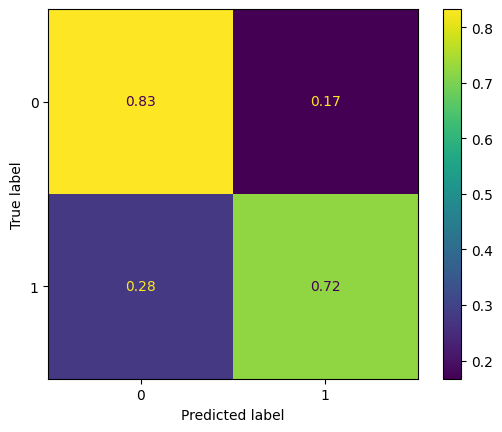

In [73]:
ConfusionMatrixDisplay.from_predictions(y_test, lgb_grid.best_estimator_.predict(X_test), normalize = "true")
plt.show()

### EXTRA: Comparación de errores con probabilidades en clase 1

*En el caso de una clasificación binaria la matriz de confusión nos dice lo evidente, nos equivocamos en dirección de la otra clase. Por eso puede ser más interesante ver instancias individuales, por ejemplo en la clase 1, con probabilidad alta*

In [63]:
# la probabilidad predicha de la clase 1
y_proba = lgb_grid.best_estimator_.predict_proba(X_test)[:,1]
y_proba

array([0.09585632, 0.23083732, 0.04761525, ..., 0.79052356, 0.18380134,
       0.86844574])

In [ ]:
# Obtener la clase final predicha por el modelo (0 o 1)
y_pred = lgb_grid.best_estimator_.predict(X_test)

# generar nuevo dataset con predict_proba y la probabilidad predicha de la clase 1
error_set = test_set.copy()
error_set["proba"] = y_proba
error_set["predict_class"] = y_pred

# Identificar observaciones bien/mal clasificadas
bien_clasificadas = error_set[target] == error_set["predict_class"]
mal_clasificadas = bien_clasificadas == False

# Identificar observaciones cuya clase real es 1
clase_1 = error_set[target] == 1

In [76]:
error_set.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,proba,predict_class
count,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000
mean,0.068979,0.329057,52.160287,0.508373,1.710807,6920.253589,8.466108,0.379585,1.023525,0.335726,0.837321,0.278398,0.205742
std,0.253469,0.358841,15.047426,5.202360,8.439761,14055.100758,5.215122,5.194296,1.148283,5.178479,1.177780,0.261964,0.404323
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002600,0.000000
25%,0.000000,0.032359,41.000000,0.000000,0.143144,3600.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.069003,0.000000
50%,0.000000,0.163942,51.000000,0.000000,0.296270,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.181991,0.000000
75%,0.000000,0.573764,63.000000,0.000000,0.505631,8198.500000,11.000000,0.000000,2.000000,0.000000,1.000000,0.432232,0.000000
max,1.000000,2.239601,95.000000,98.000000,97.000000,629000.000000,40.000000,98.000000,16.000000,98.000000,8.000000,0.987973,1.000000


<Axes: >

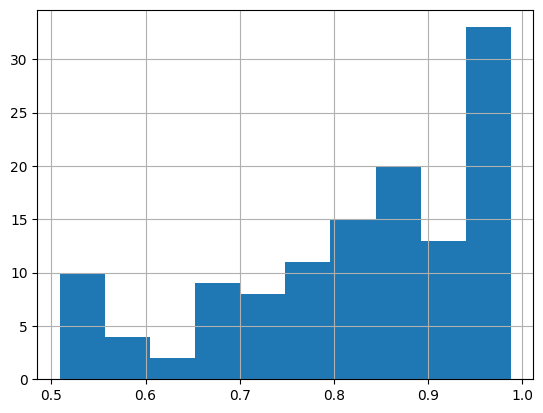

In [64]:
# Probabilidades altas y acumuladas cerca de 1
# Esto indica que cuando el modelo acierta en clase 1, lo hace con alta confianza.
error_set[bien_clasificadas & clase_1].proba.hist()

<Axes: >

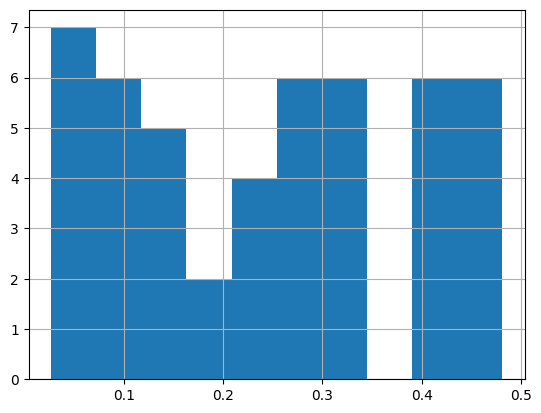

In [51]:
# Probabilidades distribuidas más o menos uniformemente
# El modelo estaba indeciso, asignando baja o media probabilidad a la clase 1.

error_set[mal_clasificadas & clase_1].proba.hist()

*Este gráfico nos dice que cuando se equivoca con la clase 1 lo hace con probabilidades más o menos igual distribuidas, frente a cuando lo hace bien que se ve que se acumulan los exitos en probabilidades altas, podríamos intentar ver que caracteriza a estos errores o a los de probabilidades más bajas de 0.25 o menos por entender si hay algo que esté sesgando al modelo, y corregirlo*

**El modelo falla más cuando no está seguro**.  
Lo interesante sería **buscar patrones en esos casos**:

- Variables con rangos raros
- Subgrupos de la población que el modelo no ve
- Posibles sesgos de muestreo

**podríamos tomar las siguientes decisiones**:

- Crear nuevas features
- Rebalancear dataset
- Ajustar threshold (menor a 0.5. ejemplo threshold = 0.3) 